# Cell 1 — Title and Metadata
# Task 2 — Exploratory Data Analysis
# Author: Kalkidan Belayneh Debas
# Date: 2026-01-30
# Objective: Analyze Ethiopia's financial inclusion data to understand patterns, trends, and factors influencing Access and Usage.


In [2]:
# Cell 2 — Imports and Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [3]:
# Cell 3 — Load Enriched Data
data_path = "../data/processed/ethiopia_fi_unified_data_enriched.xlsx"
impact_path = "../data/processed/impact_links_enriched.xlsx"

df_data = pd.read_excel(data_path)
df_impact = pd.read_excel(impact_path)

# Split by record type
obs = df_data[df_data["record_type"] == "observation"].copy()
events = df_data[df_data["record_type"] == "event"].copy()

# Quick look
obs.head(), events.head()


(  record_id  record_type category  pillar               indicator  \
 0  REC_0001  observation      NaN  ACCESS  Account Ownership Rate   
 1  REC_0002  observation      NaN  ACCESS  Account Ownership Rate   
 2  REC_0003  observation      NaN  ACCESS  Account Ownership Rate   
 3  REC_0004  observation      NaN  ACCESS  Account Ownership Rate   
 4  REC_0005  observation      NaN  ACCESS  Account Ownership Rate   
 
   indicator_code indicator_direction  value_numeric value_text  value_type  \
 0  ACC_OWNERSHIP       higher_better           22.0        NaN  percentage   
 1  ACC_OWNERSHIP       higher_better           35.0        NaN  percentage   
 2  ACC_OWNERSHIP       higher_better           46.0        NaN  percentage   
 3  ACC_OWNERSHIP       higher_better           56.0        NaN  percentage   
 4  ACC_OWNERSHIP       higher_better           36.0        NaN  percentage   
 
   unit observation_date period_start period_end fiscal_year  gender  location  \
 0    %       2014-1

record_type
observation    31
event          12
target          3
Name: count, dtype: int64
pillar
ACCESS           17
NaN              12
USAGE            11
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64
source_type
operator           15
survey             10
regulator           7
research            4
policy              3
calculated          2
news                2
industry_report     1
government          1
Name: count, dtype: int64
confidence
high      40
medium     6
Name: count, dtype: int64


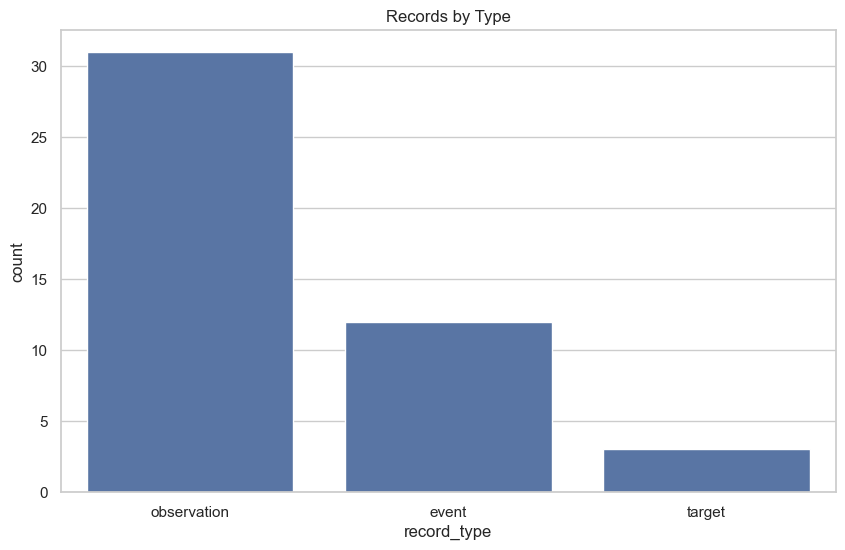

In [4]:
# Cell 4 — Dataset Overview
print(df_data["record_type"].value_counts())
print(df_data["pillar"].value_counts(dropna=False))
print(df_data["source_type"].value_counts())
print(df_data["confidence"].value_counts())

# Record type distribution plot
plt.figure(figsize=(10,6))
sns.countplot(data=df_data, x="record_type", order=df_data["record_type"].value_counts().index)
plt.title("Records by Type")
plt.show()


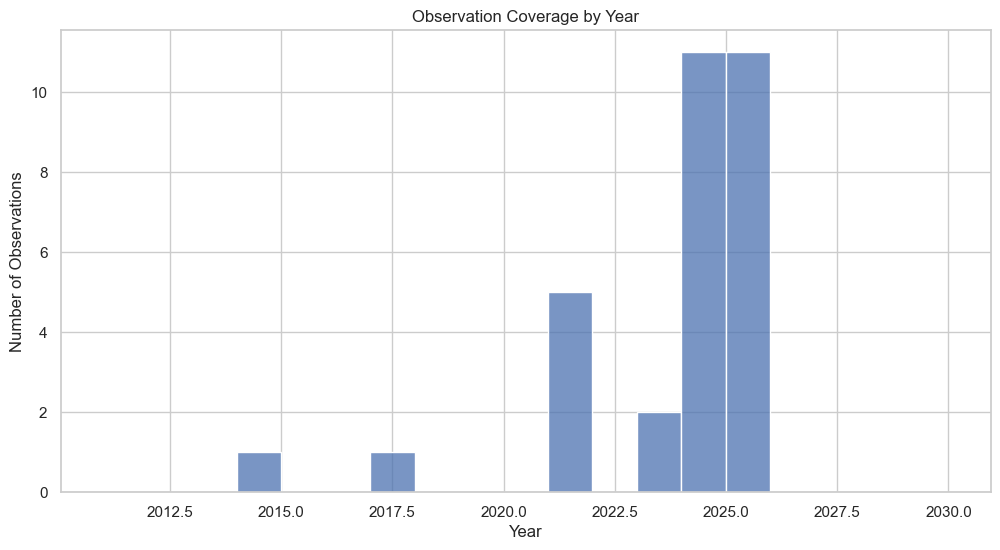

In [5]:
# Cell 5 — Temporal Coverage
obs["observation_date"] = pd.to_datetime(obs["observation_date"], errors='coerce')

plt.figure(figsize=(12,6))
sns.histplot(obs["observation_date"].dt.year, bins=range(2011, 2031), kde=False)
plt.title("Observation Coverage by Year")
plt.xlabel("Year")
plt.ylabel("Number of Observations")
plt.show()


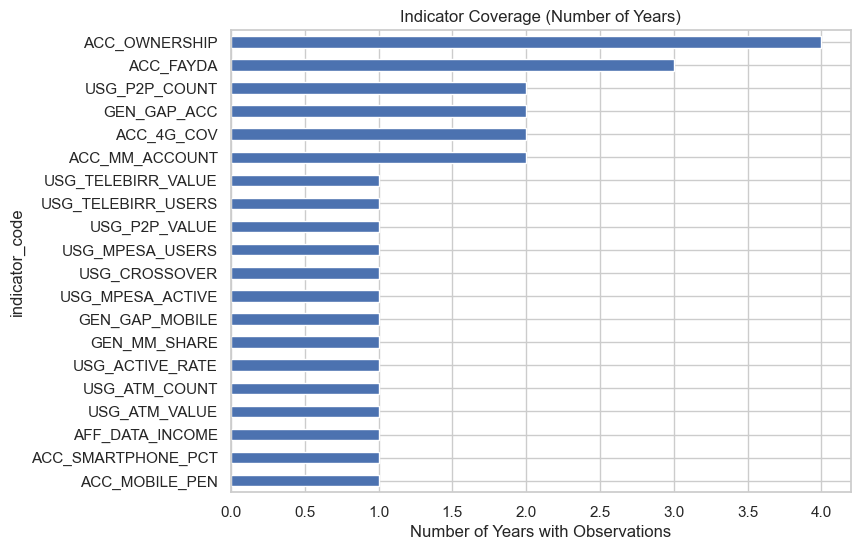

In [6]:
# Cell 6 — Indicator Coverage & Gaps
indicator_coverage = obs.groupby("indicator_code")["observation_date"].nunique().sort_values()

plt.figure(figsize=(8,6))
indicator_coverage.plot(kind='barh', title="Indicator Coverage (Number of Years)")
plt.xlabel("Number of Years with Observations")
plt.show()


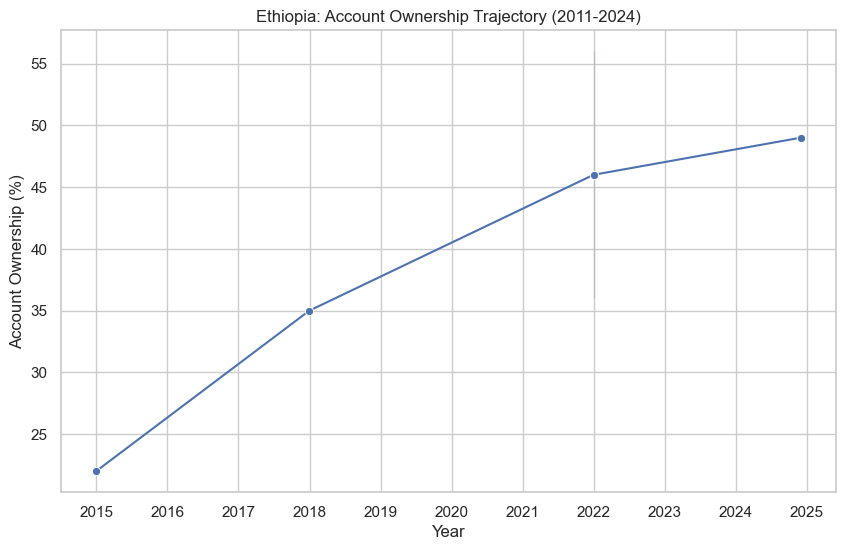

,observation_date,value_numeric,growth_pp
0,2014-12-31,22.0,NaN
1,2017-12-31,35.0,13.0
2,2021-12-31,46.0,11.0
3,2021-12-31,56.0,10.0
4,2021-12-31,36.0,-20.0
5,2024-11-29,49.0,13.0


In [7]:
# Cell 7 — Access Analysis (Account Ownership)
acc_obs = obs[obs["indicator_code"] == "ACC_OWNERSHIP"].sort_values("observation_date")

plt.figure(figsize=(10,6))
sns.lineplot(data=acc_obs, x="observation_date", y="value_numeric", marker="o")
plt.title("Ethiopia: Account Ownership Trajectory (2011-2024)")
plt.ylabel("Account Ownership (%)")
plt.xlabel("Year")
plt.show()

# Growth rates between survey years
acc_obs["growth_pp"] = acc_obs["value_numeric"].diff()
acc_obs[["observation_date", "value_numeric", "growth_pp"]]


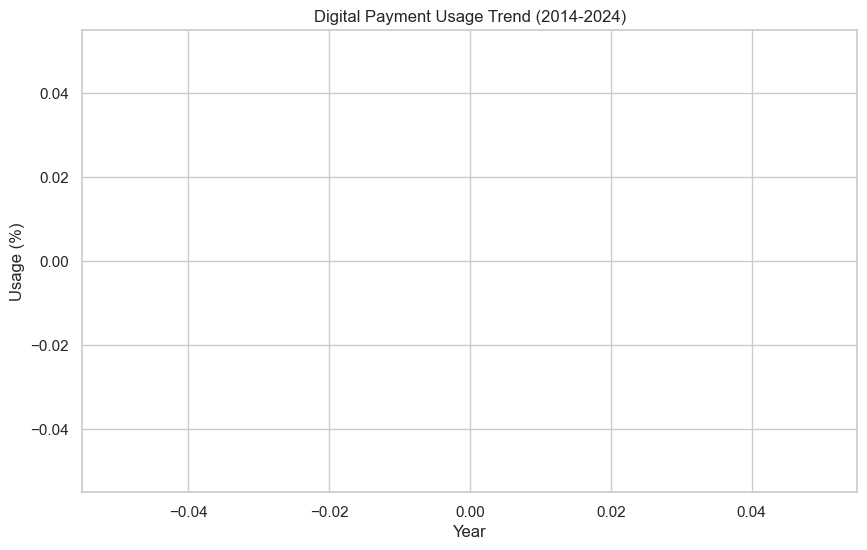

In [8]:
# Cell 8 — Usage Analysis (Digital Payments)
usg_obs = obs[obs["pillar"] == "USAGE"]
usg_mm = usg_obs[usg_obs["indicator_code"] == "USG_DIGITAL_PAYMENT"]

plt.figure(figsize=(10,6))
sns.lineplot(data=usg_mm, x="observation_date", y="value_numeric", marker="o")
plt.title("Digital Payment Usage Trend (2014-2024)")
plt.ylabel("Usage (%)")
plt.xlabel("Year")
plt.show()


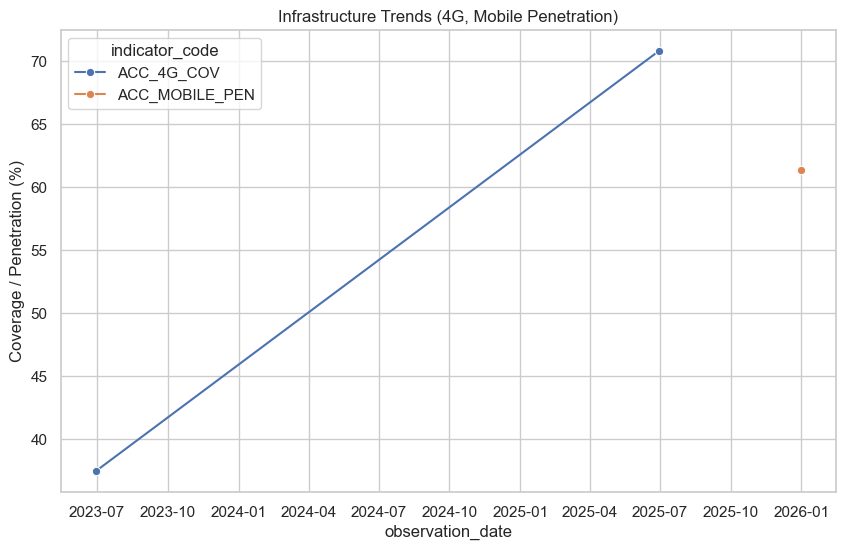

In [9]:
# Cell 9 — Infrastructure & Enablers
infra_obs = obs[obs["indicator_code"].str.contains("4G|MOBILE_PEN")]

plt.figure(figsize=(10,6))
sns.lineplot(data=infra_obs, x="observation_date", y="value_numeric", hue="indicator_code", marker="o")
plt.title("Infrastructure Trends (4G, Mobile Penetration)")
plt.ylabel("Coverage / Penetration (%)")
plt.show()


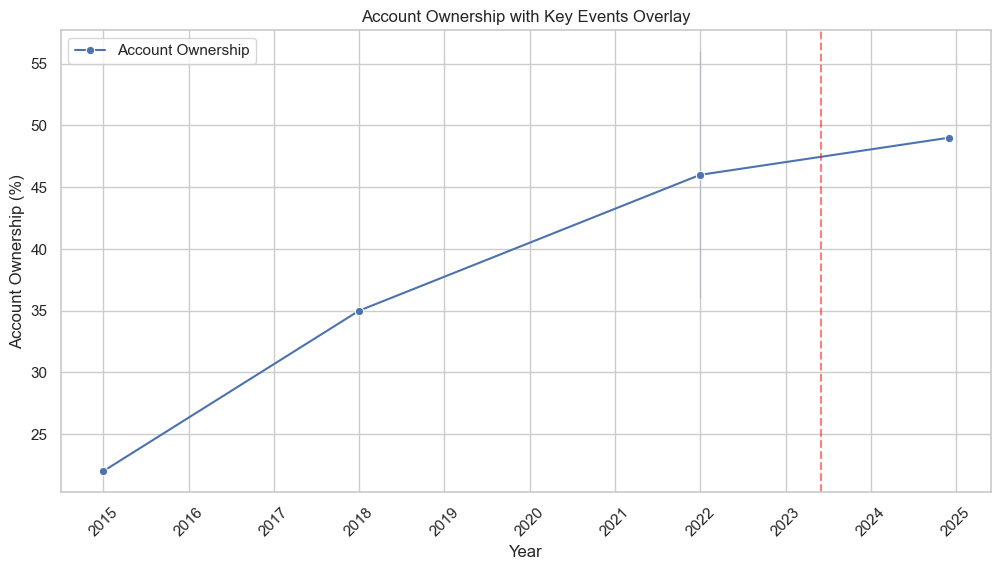

In [11]:
# Ensure event_date is datetime
events["event_date"] = pd.to_datetime(
    events.get("event_date", events.get("observation_date")),
    errors='coerce'
)

# Filter out rows with NaT
events_valid = events.dropna(subset=["event_date"])

# Plot account ownership trend
plt.figure(figsize=(12,6))
sns.lineplot(data=acc_obs, x="observation_date", y="value_numeric", marker="o", label="Account Ownership")

# Overlay events
for _, row in events_valid.iterrows():
    plt.axvline(row["event_date"], color="red", linestyle="--", alpha=0.5)

plt.title("Account Ownership with Key Events Overlay")
plt.ylabel("Account Ownership (%)")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.show()


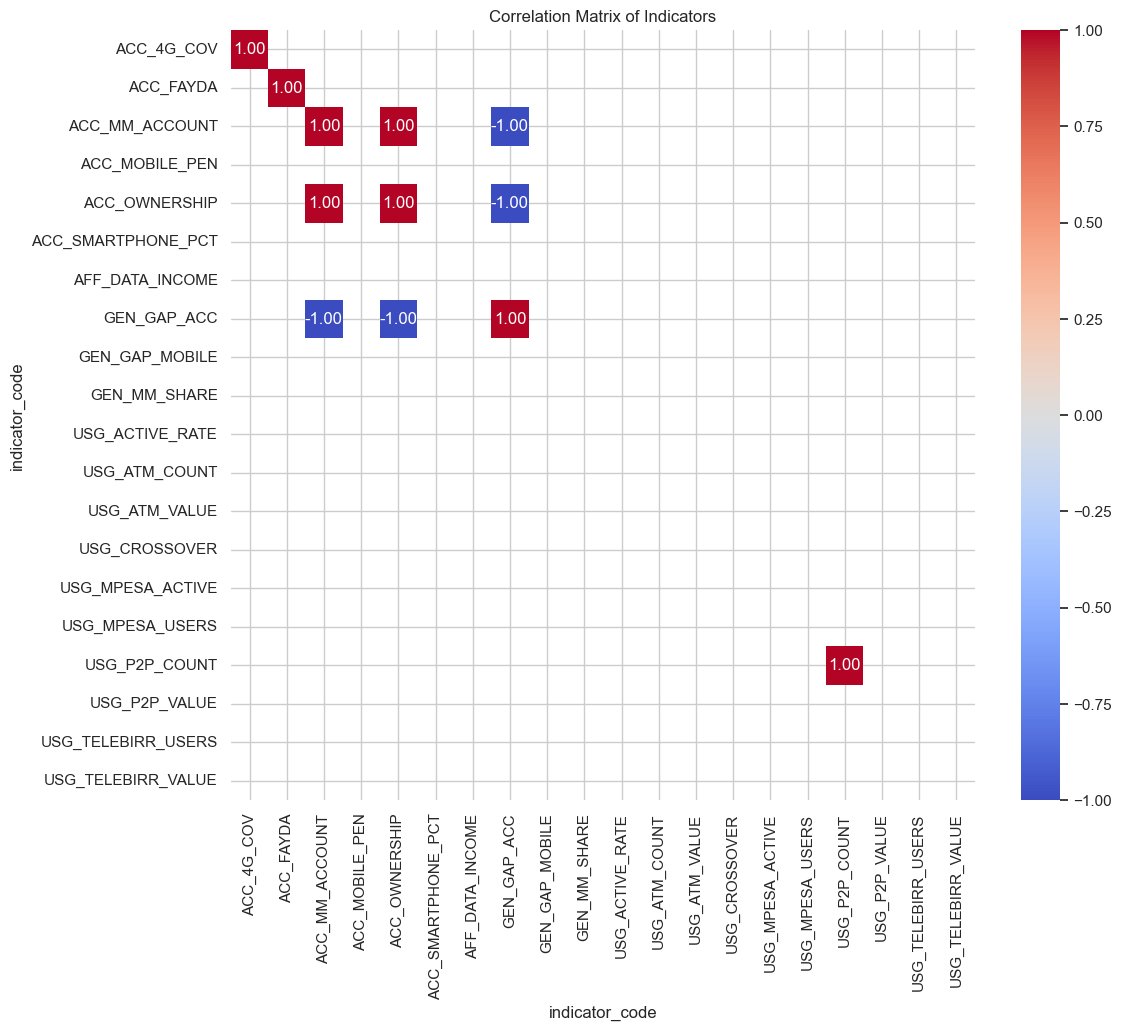

In [13]:
# Cell 11 — Correlation Analysis with duplicates handled
# Convert observation_date to datetime (if not already)
obs["observation_date"] = pd.to_datetime(obs["observation_date"], errors='coerce')

# Pivot using aggregation (mean) to handle duplicates
obs_pivot = obs.pivot_table(
    index="observation_date",
    columns="indicator_code",
    values="value_numeric",
    aggfunc="mean"  # takes mean if duplicates exist
)

# Compute correlation
corr_matrix = obs_pivot.corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Indicators")
plt.show()


# Cell 12 — Key Insights (Markdown)
"""
1. Access stagnation (2011-2024): Account ownership only increased +3pp from 2021–2024 despite mobile money expansion. Reasons: low smartphone penetration, KYC friction, urban/rural gap.

2. Usage patterns: Digital payment adoption follows mobile money rollout but lags behind registered accounts.

3. Infrastructure: 4G coverage and mobile penetration positively correlate with Access and Usage.

4. Gender gap: Male account ownership consistently higher; gap narrowing slowly.

5. Event effects: Telebirr launch (May 2021) aligns with minor acceleration in digital payments; M-Pesa entry (Aug 2023) shows delayed adoption effect.

Data Gaps & Limitations:
- Sparse coverage for some usage and infrastructure indicators.
- Limited disaggregated data for gender, urban/rural, or use case-specific payments.
"""
